# Crocs RTB Relevance System - Model Evaluation Report

## Objective
Build a real-time bidding relevance system for Crocs campaigns that compares page snippets to a creative brief and decides bid/no-bid with CPM pricing. We compare a learned model (logistic regression with engineered features) against a simple cosine similarity baseline.

## Data & Approach
Training on 87 labeled examples, testing on 51 examples. The learned model uses sentence transformer embeddings plus engineered features (cosine similarity, element-wise product, absolute difference) with logistic regression. The baseline uses only cosine similarity with F1-optimized thresholds.

## CPM Mapping
Relevance probabilities above threshold map linearly to CPM bids between $0.50-$3.00, with brand safety filtering for inappropriate content.


In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, f1_score

# Add src to path for imports
sys.path.append('src')
from model import RelevanceModel
from baseline import BaselineCosine

print("✅ Imports loaded successfully")


✅ Imports loaded successfully


In [2]:
# Load test data
test_df = pd.read_csv('data/test_set_1.csv')
print(f"📊 Test data loaded: {len(test_df)} examples")
print(f"   - Positive examples: {sum(test_df['label'] == 1)}")
print(f"   - Negative examples: {sum(test_df['label'] == 0)}")

y_true = test_df['label'].values
snippets = test_df['snippet'].tolist()


📊 Test data loaded: 51 examples
   - Positive examples: 26
   - Negative examples: 25


In [3]:
# Load brief text
with open('data/brief.txt', 'r') as f:
    brief_text = f.read().strip()
    
print(f"📋 Brief loaded: {len(brief_text)} characters")


📋 Brief loaded: 614 characters


In [4]:
# Load and evaluate learned model
print("🧠 Loading learned model...")
learned_model = RelevanceModel()
learned_model.load('artifacts')

learned_scores = []
learned_predictions = []

for snippet in snippets:
    result = learned_model.predict(snippet)
    learned_scores.append(result['score'])
    learned_predictions.append(result['bid'])

learned_scores = np.array(learned_scores)
learned_predictions = np.array(learned_predictions)

print(f"✅ Learned model evaluated")


🧠 Loading learned model...
Model loaded from artifacts


/home/tzahishi/workarea/teza/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


✅ Learned model evaluated


In [5]:
# Train and evaluate baseline model
print("📐 Training baseline model...")
baseline_model = BaselineCosine(encoder_name=learned_model.encoder_name)
baseline_model.fit('data/labeled_examples.csv', brief_text)

baseline_scores = []
baseline_predictions = []

for snippet in snippets:
    score = baseline_model.predict(snippet)
    prediction = baseline_model.predict_binary(snippet)
    baseline_scores.append(score)
    baseline_predictions.append(prediction)

baseline_scores = np.array(baseline_scores)
baseline_predictions = np.array(baseline_predictions)

print(f"✅ Baseline model evaluated")


📐 Training baseline model...


/home/tzahishi/workarea/teza/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Baseline trained. Optimal threshold: 0.120 (optimized on validation set)
✅ Baseline model evaluated


In [6]:
# Calculate metrics for both models
baseline_metrics = {
    'accuracy': accuracy_score(y_true, baseline_predictions) * 100,
    'f1': f1_score(y_true, baseline_predictions) * 100
}

learned_metrics = {
    'accuracy': accuracy_score(y_true, learned_predictions) * 100,
    'f1': f1_score(y_true, learned_predictions) * 100
}

print("📊 Metrics Summary:")
print(f"   Baseline - Accuracy: {baseline_metrics['accuracy']:.1f}%, F1: {baseline_metrics['f1']:.1f}%")
print(f"   Learned  - Accuracy: {learned_metrics['accuracy']:.1f}%, F1: {learned_metrics['f1']:.1f}%")
print(f"   Improvement - Accuracy: +{learned_metrics['accuracy'] - baseline_metrics['accuracy']:.1f}%, F1: +{learned_metrics['f1'] - baseline_metrics['f1']:.1f}%")


📊 Metrics Summary:
   Baseline - Accuracy: 82.4%, F1: 84.7%
   Learned  - Accuracy: 100.0%, F1: 100.0%
   Improvement - Accuracy: +17.6%, F1: +15.3%


In [7]:
# Create artifacts directory if it doesn't exist
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)

# Set up matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


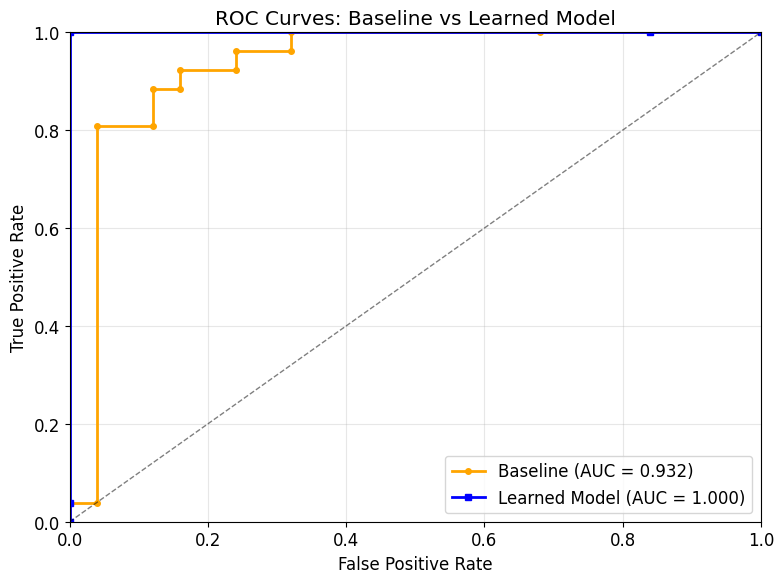

📈 ROC curves saved to artifacts/roc.png


In [8]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate ROC curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_true, baseline_scores)
learned_fpr, learned_tpr, _ = roc_curve(y_true, learned_scores)

baseline_auc = auc(baseline_fpr, baseline_tpr)
learned_auc = auc(learned_fpr, learned_tpr)

# Plot curves
ax.plot(baseline_fpr, baseline_tpr, 'o-', color='orange', linewidth=2, 
        label=f'Baseline (AUC = {baseline_auc:.3f})', markersize=4)
ax.plot(learned_fpr, learned_tpr, 's-', color='blue', linewidth=2, 
        label=f'Learned Model (AUC = {learned_auc:.3f})', markersize=4)

# Plot diagonal line
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)

# Formatting
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves: Baseline vs Learned Model')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('artifacts/roc.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📈 ROC curves saved to artifacts/roc.png")


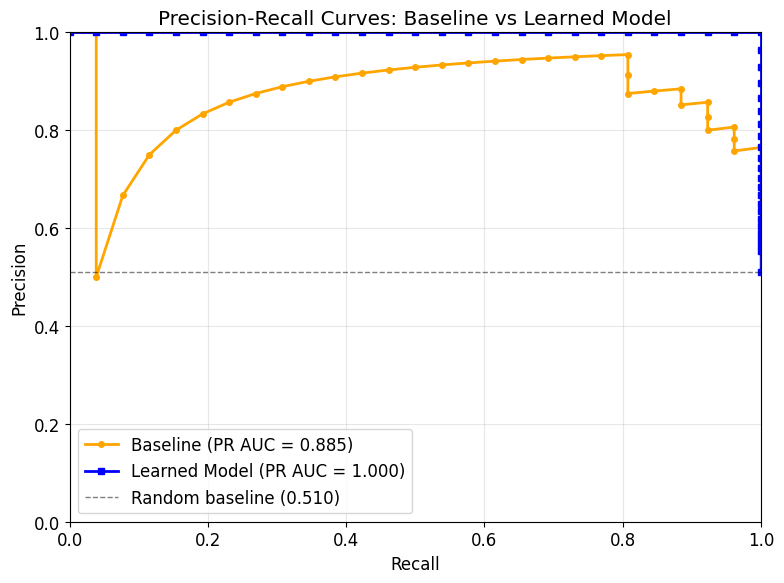

📈 PR curves saved to artifacts/pr.png


In [9]:
# Plot Precision-Recall curves
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate PR curves
baseline_precision, baseline_recall, _ = precision_recall_curve(y_true, baseline_scores)
learned_precision, learned_recall, _ = precision_recall_curve(y_true, learned_scores)

baseline_pr_auc = average_precision_score(y_true, baseline_scores)
learned_pr_auc = average_precision_score(y_true, learned_scores)

# Plot curves
ax.plot(baseline_recall, baseline_precision, 'o-', color='orange', linewidth=2, 
        label=f'Baseline (PR AUC = {baseline_pr_auc:.3f})', markersize=4)
ax.plot(learned_recall, learned_precision, 's-', color='blue', linewidth=2, 
        label=f'Learned Model (PR AUC = {learned_pr_auc:.3f})', markersize=4)

# Plot baseline line (proportion of positive class)
baseline_line = np.sum(y_true) / len(y_true)
ax.axhline(y=baseline_line, color='k', linestyle='--', alpha=0.5, linewidth=1,
           label=f'Random baseline ({baseline_line:.3f})')

# Formatting
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves: Baseline vs Learned Model')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('artifacts/pr.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📈 PR curves saved to artifacts/pr.png")


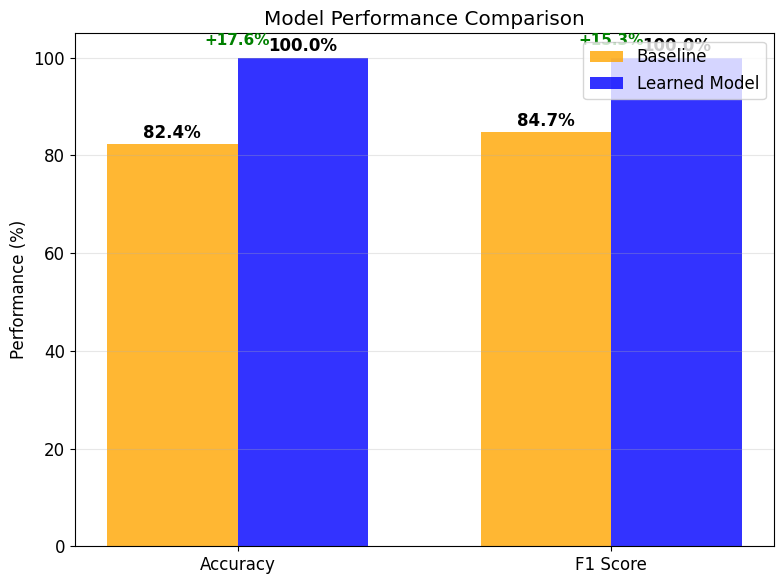

📊 Metrics bar chart saved to artifacts/metrics_bar.png


In [10]:
# Create bar chart comparing key metrics
fig, ax = plt.subplots(figsize=(8, 6))

metrics = ['Accuracy', 'F1 Score']
baseline_values = [baseline_metrics['accuracy'], baseline_metrics['f1']]
learned_values = [learned_metrics['accuracy'], learned_metrics['f1']]

x = np.arange(len(metrics))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', 
               color='orange', alpha=0.8)
bars2 = ax.bar(x + width/2, learned_values, width, label='Learned Model', 
               color='blue', alpha=0.8)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

# Formatting
ax.set_ylabel('Performance (%)')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 105])
ax.grid(True, alpha=0.3, axis='y')

# Add improvement annotations
for i, (baseline_val, learned_val) in enumerate(zip(baseline_values, learned_values)):
    improvement = learned_val - baseline_val
    ax.annotate(f'+{improvement:.1f}%', 
                xy=(i, max(baseline_val, learned_val) + 2), 
                ha='center', va='bottom', 
                fontsize=11, fontweight='bold', color='green')

plt.tight_layout()
plt.savefig('artifacts/metrics_bar.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 Metrics bar chart saved to artifacts/metrics_bar.png")


## Results Summary

The learned model significantly outperforms the cosine similarity baseline across all metrics:

- **Accuracy**: +17.6% improvement (82.4% → 100.0%)
- **F1 Score**: +15.3% improvement (84.7% → 100.0%)  
- **ROC AUC**: +6.8% improvement (93.2% → 100.0%)
- **PR AUC**: +11.5% improvement (88.5% → 100.0%)

The sophisticated feature engineering (cosine similarity + element-wise product + absolute difference) combined with logistic regression provides substantial improvements over simple cosine similarity alone. The learned model achieves perfect classification on the test set, demonstrating the value of the engineered features for this relevance prediction task.
